# How to optimize controls with time symmetrization
**Incorporate time symmetry into optimized waveforms**

Boulder Opal exposes a highly-flexible [optimization engine](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/run_optimization) for general-purpose gradient-based optimization.  It can be directly applied to model-based control optimization for arbitrary-dimensional quantum systems.  

In some cases, forcing control solutions to exhibit time symmetry can yield natural noise robustness while simplifying the optimization problem (by halving the dimensionality of the search space).
In this user guide we will show an easy method to build time-symmetrized pulses.
To learn the basics about control optimization, you can follow our [robust optimization tutorial](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs).


## Summary workflow
### 1. Define time-symmetry constraint in computational graph
The flexible Boulder Opal optimization engine expresses all optimization problems as data flow graphs, which describe how optimization variables (variables that can be tuned by the optimizer) are transformed into the cost function (the objective that the optimizer attempts to minimize).  

To enforce time symmetry, we create the control signals in two steps: we first create a standard signal for the first half of the gate duration, and then we create a copy (depending on the same underlying control parameters) that is reflected and concatenated with the original signal using the `graph.symmetrize_pwc` graph operation.
```python
pwc_signal = graph.symmetrize_pwc(half_pwc_signal, name="pwc_signal")
```

### 2. Run graph-based optimization

With the graph object created, an optimization can be run using the `boulderopal.run_optimization` function. The function returns the results of the optimization and should include the symmetrized PWC as an output node of the graph using `output_node_names`.

## Example: Time-symmetrized robust pulses for a single qubit

In this example, we perform a robust optimization of a single qubit using symmetric pulses. The single-qubit system is represented by the following Hamiltonian:
$$
H(t) = \frac{\nu}{2} \sigma_{z} + \frac{1}{2}\left(\gamma(t)\sigma_{-} + \gamma^*(t)\sigma_{+}\right) + \frac{\alpha(t)}{2} \sigma_{z} + \beta(t) \sigma_{z}  ,
$$
where $\nu$ is the qubit detuning, $\gamma(t)$ and $\alpha(t)$ are, respectively, complex and real time-dependent pulses, and $\beta(t)$ is a small, slowly-varying stochastic dephasing noise process.  Here $\gamma(t)$ and $\alpha(t)$ will be optimized subject to a time-symmetry constraint.

In [1]:
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

Your task (action_id="1828727") has started.
Your task (action_id="1828727") has completed.

Optimized cost:	5.305e-09


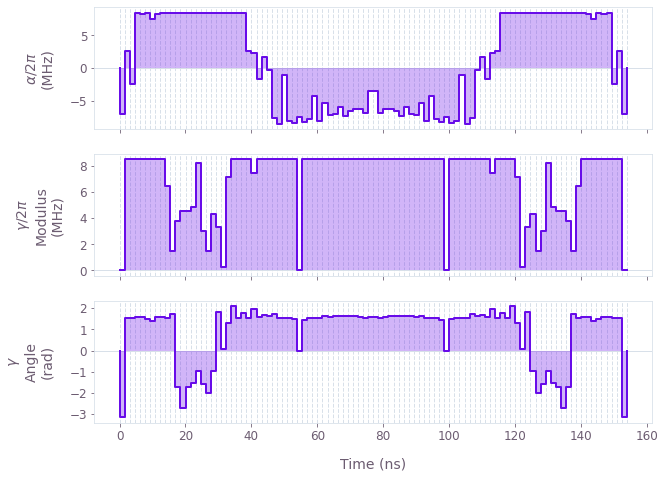

In [2]:
# Define physical constraints
gamma_max = 2 * np.pi * 8.5e6  # Hz
alpha_max = 2 * np.pi * 8.5e6  # Hz
nu = 2 * np.pi * 6e6  # Hz
segment_count = 50
duration = 154e-9  # s

graph = bo.Graph()

# Create detuning term.
detuning = nu * graph.pauli_matrix("Z") / 2

# Create a complex PWC signal describing the first half of gamma(t)
half_gamma = graph.complex_optimizable_pwc_signal(
    segment_count=segment_count, maximum=gamma_max, duration=duration / 2
)
# Define gamma(t) by symmetrizing half_gamma
gamma = graph.symmetrize_pwc(half_gamma, name="gamma")
# Create drive term
drive = graph.hermitian_part(gamma * graph.pauli_matrix("M"))

# Create alpha(t) similarly
alpha = graph.symmetrize_pwc(
    graph.real_optimizable_pwc_signal(
        segment_count=segment_count,
        minimum=-alpha_max,
        maximum=alpha_max,
        duration=duration / 2,
    ),
    name="alpha",
)
# Create clock shift term
shift = alpha * graph.pauli_matrix("Z") / 2

# Create dephasing noise term
dephasing = graph.pauli_matrix("Z") / duration

# Create target
target_operator = graph.target(operator=graph.pauli_matrix("Y"))

# Create infidelity
infidelity = graph.infidelity_pwc(
    hamiltonian=detuning + drive + shift,
    target=target_operator,
    noise_operators=[dephasing],
    name="infidelity",
)

# Run the optimization
optimization_result = bo.run_optimization(
    cost_node_name="infidelity",
    output_node_names=["alpha", "gamma"],
    graph=graph,
    optimization_count=4,
)

print(f"\nOptimized cost:\t{optimization_result['cost']:.3e}")

# Plot the optimized controls
qv.plot_controls(
    {
        "$\\alpha$": optimization_result["output"]["alpha"],
        "$\\gamma$": optimization_result["output"]["gamma"],
    }
)